In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import boto3
from dynamo import *
from utils import *
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorly.decomposition import non_negative_parafac
import tensorly as tl

Be sure to set the aws key and secret as environment variables so that it is obfuscated

In [3]:
AWS_KEY = os.environ['AWS_KEY']
AWS_SECRET = os.environ['AWS_SECRET']

Instantiate a resource client to interacte with dynamodb. 

In [4]:
db = boto3.resource(service_name='dynamodb',
                    region_name='us-east-1',
                    aws_access_key_id=AWS_KEY,
                    aws_secret_access_key=AWS_SECRET)

In dynamodb, there are no primary keys, foreign keys, etc like there are for SQL type databases. Instead, it is a NoSQL database which uses partitions and sort keys. The partition acts as a type of a primary key in that it must be unique. But more importantly, the data is "partitioned" into 10GB clusters based off of the partition keys. From there, the data is separated further by sort keys. You can read more about it if you're interested, here:

* https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/HowItWorks.CoreComponents.html

* https://aws.amazon.com/blogs/database/choosing-the-right-dynamodb-partition-key/

For our schema, I've made it so that the years are the partition key, and then the sort keys are a combination of 

$$ [month].[day].[uid]$$

For example, a random article from January 20th, 2019 would be encoded like

| partition key | sort key    |
|---------------|-------------|
| 2019          | 1.20.342320 |

The [uid] part in the sort key comes from a sequentially generated number from the original dataset. The first row in the data was given the value of 0, the second row the value of 1, the 380th row the value of 379, etc etc. There was about 2.5 million rows of data, so the [uid] number in the sort key will be some number between 0 and 2.5 million. It really doesn't have an affect on anything however. All the queries in the backend are happening only dependent on the year and the first two values of the sort key. 

If you have a year and uid of interest and you just want to see what a query response looks like, there is a function that is imported from the dynamo module called **single_query** that takes in a year, uid, and the db object you instantiate at the beginning of this notebook

In [5]:
#uid from Jan 9th, 2019
sample_uid = '1.9.999730'

In [6]:
bows, year, uid, file = single_query(year=2019, uid=sample_uid, dynamodb=db)

The data is stored as individual items with, obviously, a partion of **"year"**, and sort of **"uid"**, but then each item has an attribute of **"bows"** or bag of words, and **"file"** which is the csv file which contains the entire original observation data in the S3 bucket it was written to after being processed by spark in the EMR cluster. 

In [7]:
#bows
bows

['nothing',
 'awkward',
 'handshake',
 'hug',
 'congratulate',
 'someone',
 'â',
 'one',
 'moment',
 'play',
 'right',
 'stage',
 'golden',
 'globe',
 'nicole',
 'kidman',
 'present',
 'award',
 'rami',
 'malek',
 'rest',
 'cast',
 'bohemian',
 'rhapsody',
 'malek',
 'reach',
 'thank',
 'kidman',
 'award',
 'promptly',
 'turn',
 'back',
 'much',
 'leave',
 'hangingâ',
 'jimmy',
 'kimmel',
 'live',
 'malek',
 'visibly',
 'cringe',
 'watch',
 'clip',
 'moment',
 'laugh',
 'explain',
 'fact',
 'kidman',
 'many',
 'yearsâ',
 'seth',
 'meyers',
 'brutally',
 'outline',
 'good',
 'bad',
 'case',
 'scenario',
 'democratic',
 'candidate',
 'stephen',
 'colbert',
 'bust',
 'good',
 'bon',
 'jovi',
 'impression',
 'roast',
 'democratic',
 'candidate',
 'hasan',
 'minhajs',
 'dad',
 'hilariously',
 'destroy',
 'high',
 'school',
 'cheat',
 'scandal',
 'reason',
 'drop',
 'chill',
 'season',
 'trailer']

In [8]:
print('Year: {}\nUID: {}\nFile: {}'.format(year, uid, file))

Year: 2019
UID: 1.9.999730
File: clean2/part-00023-b4b7a76c-5eee-4096-bb2b-80b5d3ce1306-c000.csv


You can go to the S3 bucket and download it if you wish to see all the other features about the item, such as author, publication, title, original article, etc.) Or you can simply enter the url for the file in your browser to download it. It is simply the url for the bucket + the filename. 

E.g. for the the file shown above, in order to download it, you would go to the url

$$\text{https://largedatabucket.s3.amazonaws.com/clean2/part-00010-b4b7a76c-5eee-4096-bb2b-80b5d3ce1306-c000.csv}$$

Parallel Processing & Caching
------------------------

So since there's sooooo many data points, obviously we have to sample a certain amount of articles per month for a yearly analysis. I've also now added the capability to sample a certain amount of articles per day to perform a monthly analysis (How topics evovle over the course of the days in a month).

However, before any of that can happen, I've designed the workflow such that for either a given month or a given year, which ever analysis you're trying to do, the algorithm will first query all the UIDs for the month or year and cache them on your local system. I did this as a cost savings workflow. Querying DynamoDB is not free, so in order to reduce the amount of queries, the UIDs are downloaded in entirety and then cached. Once this has happened once, you won't have to do this again. All algorithms will sample from the cached UIDs and then query the DB for only those items with respect to the sampled UIDs. If I didn't do this, the alternative would have been having to transmit all observations for a given month or a given year (on average each month has about 50,000 data points, and each year has on average 600,000 data points), then randomly sample the data which you want to use for the analysis. That would be very time consuming and rack up the charges.

The implementation which gets and caches the UIDs, as well as sample local UIDs is a multiprocess (parallel) implementation. This means the execution of this task will utilize all the cores of your processor and spawn as many processes as possible in order to query / sample in parallel as opposed to an extremely slow single threaded implementation. Because of this, be sure to have minimal programs open on your computer when running analysis. It was a trade off in design and execution. In order to query thousands of data points in seconds, I'm trading off resources to do it. So it is resource intensive, but executes extremely fast.

There's 3 different ways to get and cache the UIDs. The first is just invoking the caching function for a given year (demonstrated below). The other two methods involve just invoking the yearly or monthly analysis function (will demonstarte in a little bit). By design, the first step in those analysis checks for cached UIDs, if they don't detect any, they retrieve and cache the uids

In [9]:
#pre-cache uids for the year 2017
#if you don't want all the output, set verbose to False
cache_uids_from_year(year=2017, dynamodb=db, throttled=False, verbose=True)

Starting.....
Creating process 1 to cache UIDs for month 1
Creating process 2 to cache UIDs for month 2
Checking for cached UIDs for 2017/1
Cache found - loading from local
Creating process 3 to cache UIDs for month 3
Checking for cached UIDs for 2017/2
Cache found - loading from local
Creating process 4 to cache UIDs for month 4
Checking for cached UIDs for 2017/3
Creating process 5 to cache UIDs for month 5
Checking for cached UIDs for 2017/4
Cache found - loading from local
Creating process 6 to cache UIDs for month 6
Cache found - loading from local
Creating process 7 to cache UIDs for month 7
Checking for cached UIDs for 2017/5
Cache found - loading from local
Checking for cached UIDs for 2017/6
Cache found - loading from local
Creating process 8 to cache UIDs for month 8
Creating process 9 to cache UIDs for month 9
Checking for cached UIDs for 2017/7
Cache found - loading from local
Checking for cached UIDs for 2017/8
Cache found - loading from local
Creating process 10 to cache 

-----------------

If you want to see the UIDs for a given month, you can use the load_cached_uids function

In [10]:
march_2017_uids = load_cached_uids(year=2017, month=3)

In [11]:
print('Total UIDs 2017-March: ',len(march_2017_uids))
print('First ten UIDs:\n{}'.format(march_2017_uids[:10]))

Total UIDs 2017-March:  51802
First ten UIDs:
['3.1.1000928' '3.1.1004276' '3.1.1004760' '3.1.1004950' '3.1.1005005'
 '3.1.1006231' '3.1.1006372' '3.1.100720' '3.1.1009826' '3.1.1011226']


# Analysis For a Given Year


If you want to sample N artcles per month and perform topic temporal extraction for a year, start off by using the bows_year function (bag of words sampled for a year). For the following example, I'm doing a small example by sampling only 10 articles per month. Since there's 10 articles and 12 months, the function should return 120 different bag of words from processed articles

In [12]:
sample_size=10
bows = bows_year(year=2017, sample_size=sample_size, dynamodb=db, throttled=False, verbose=False)

In [13]:
print('There should be 12 lists - 1 for each month: ',len(bows))
for pos, month in enumerate(bows):
    print('Num of BOWs for month {}: {}'.format(pos+1,len(month)))

There should be 12 lists - 1 for each month:  12
Num of BOWs for month 1: 10
Num of BOWs for month 2: 10
Num of BOWs for month 3: 10
Num of BOWs for month 4: 10
Num of BOWs for month 5: 10
Num of BOWs for month 6: 10
Num of BOWs for month 7: 10
Num of BOWs for month 8: 10
Num of BOWs for month 9: 10
Num of BOWs for month 10: 10
Num of BOWs for month 11: 10
Num of BOWs for month 12: 10


Next we need to vectorize the BOWs using TfidfVectorizer (or any vectorizer you wish to try). In order to do this, we need to transform each BOW from a list of words, to a single sting. So we need to go from a list of lists (12 lists containing 10 lists of BOWs) to a single list of 120 strings. We can then vectorize them using TfidfVectorizer

In [14]:
words = [' '.join(y) for x in bows for y in x]

In [15]:
vectorizer = TfidfVectorizer(max_features=10000)
X = np.array(vectorizer.fit_transform(words).todense()).astype(np.float32)

We then need to transform the now vectorized words into a tensor of dimensions [words] x [sampled articles] x [months]

In [16]:
tensor = np.dstack([X[i*sample_size:(i+1)*sample_size] for i in range(12)]).transpose(1,0,2)
print(tensor.shape)

(7433, 10, 12)


We can see, after vectorizing, it extracted 9034 unique words, and we still have 10 article samples for each of the 12 months, we then use the non_negative_parafac funtion to perform CP decomposition. Set the rank argument for however many topics you wish to extract. Since I sampled only 10 articles per month, I'll decompose for 5 topics

In [17]:
w,f = non_negative_parafac(tensor=tl.tensor(tensor), rank=5, n_iter_max=10000)

I've then create the helper functions to plot and printout the results

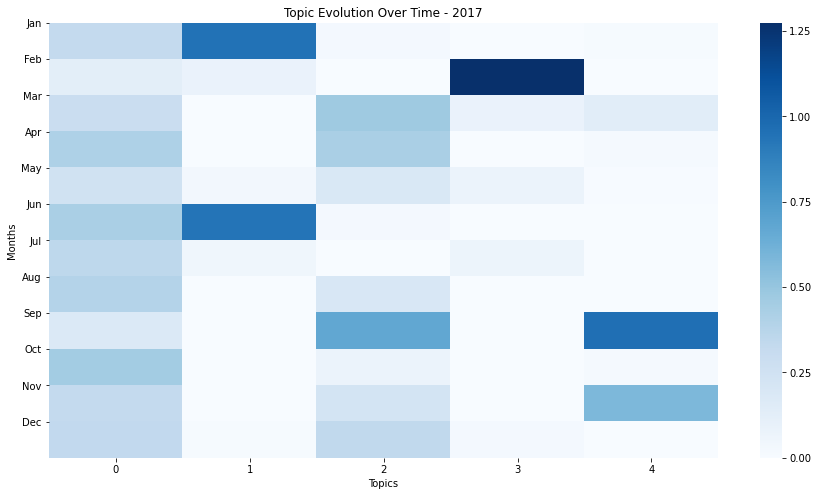

In [18]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plotit(data=f[2], title='Topic Evolution Over Time - {}'.format(2017), yaxis=months, ylabel='Months', xlabel='Topics')

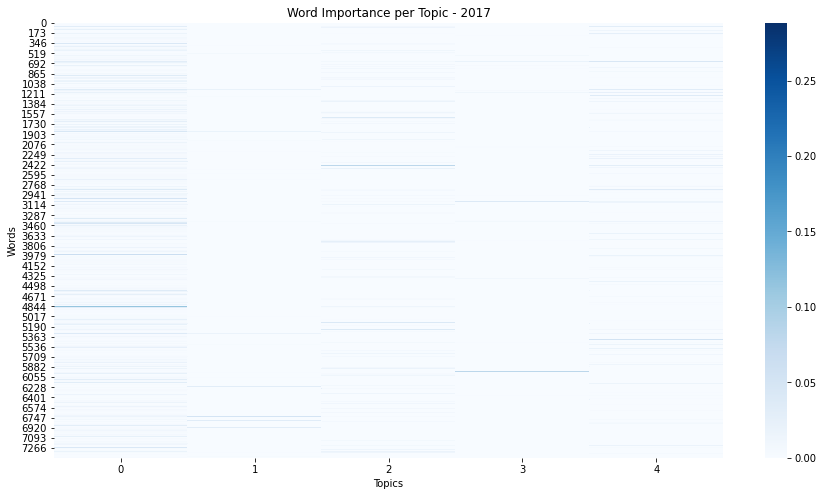

In [19]:
#visualize word importance per topic - should be mode-1 matrix
plotit(data=f[0], title='Word Importance per Topic - {}'.format(2017), ylabel='Words', xlabel='Topics')

In [20]:
#get the words for each topic
words_per_topic = [get_topics(data=f[0][:,i], threshold=0.08, vectorizer=vectorizer) for i in range(5)]
for pos, topic in enumerate(words_per_topic):
    print('\nTopic {}: {}'.format(pos, topic))


Topic 0: ['year' 'trump' 'time' 'state' 'report' 'president' 'percent' 'people'
 'one' 'news' 'new' 'make' 'law' 'facebook' 'company']

Topic 1: ['university' 'talk' 'science' 'satter' 'russian' 'russia' 'putin' 'po'
 'paris' 'moscow' 'france' 'fear' 'ceris' 'cancel' 'buzzfeed' 'book']

Topic 2: ['wedding' 'thomson' 'sourcebitlyloidu' 'share' 'sahara' 'reuter' 'pm'
 'per' 'mets' 'iverson' 'ibes' 'hospitality' 'feb' 'drink' 'dividend'
 'casino' 'baizas' 'baby' 'approve' 'agm']

Topic 3: ['zurich' 'vontobel' 'tostnet' 'text' 'share' 'sfr' 'science' 'sanofi'
 'reuter' 'repurchase' 'protein' 'outstanding' 'million' 'management'
 'japanesegooglqrqev' 'headline' 'hain' 'golf' 'company' 'ceo' 'beijing'
 'aug' 'acquisition']

Topic 4: ['trade' 'rate' 'policy' 'peace' 'japan' 'export' 'eln' 'dollar'
 'currency' 'abe']


# Analysis for a Given Month

We can also perform temporal topic extraction for a single month since each month contains so many articles. The process is pretty much the same as above except for starting off with the bow_month function instead of year function. In this case I'll still sample 10 articles, but since there's 31 days in january (the month i'm performing the analysis on), the resulting list of lists should be 31 lists of length 10

In [21]:
bows = bows_month(year=2017, month=1, sample_size=sample_size, dynamodb=db, throttled=False, verbose=False)

In [22]:
print('There should be 31 lists - 1 for each month: ',len(bows))
for pos, day in enumerate(bows):
    print('Num of BOWs for month {}: {}'.format(pos+1,len(day)))

There should be 31 lists - 1 for each month:  31
Num of BOWs for month 1: 10
Num of BOWs for month 2: 10
Num of BOWs for month 3: 10
Num of BOWs for month 4: 10
Num of BOWs for month 5: 10
Num of BOWs for month 6: 10
Num of BOWs for month 7: 10
Num of BOWs for month 8: 10
Num of BOWs for month 9: 10
Num of BOWs for month 10: 10
Num of BOWs for month 11: 10
Num of BOWs for month 12: 10
Num of BOWs for month 13: 10
Num of BOWs for month 14: 10
Num of BOWs for month 15: 10
Num of BOWs for month 16: 10
Num of BOWs for month 17: 10
Num of BOWs for month 18: 10
Num of BOWs for month 19: 10
Num of BOWs for month 20: 10
Num of BOWs for month 21: 10
Num of BOWs for month 22: 10
Num of BOWs for month 23: 10
Num of BOWs for month 24: 10
Num of BOWs for month 25: 10
Num of BOWs for month 26: 10
Num of BOWs for month 27: 10
Num of BOWs for month 28: 10
Num of BOWs for month 29: 10
Num of BOWs for month 30: 10
Num of BOWs for month 31: 10


In [23]:
words = [' '.join(y) for x in bows for y in x]

vectorizer = TfidfVectorizer(max_features=10000)
X = np.array(vectorizer.fit_transform(words).todense()).astype(np.float32)

tensor = np.dstack([X[i*sample_size:(i+1)*sample_size] for i in range(31)]).transpose(1,0,2)
print(tensor.shape)

(10000, 10, 31)


In [24]:
w,f = non_negative_parafac(tensor=tl.tensor(tensor), rank=5, n_iter_max=10000)

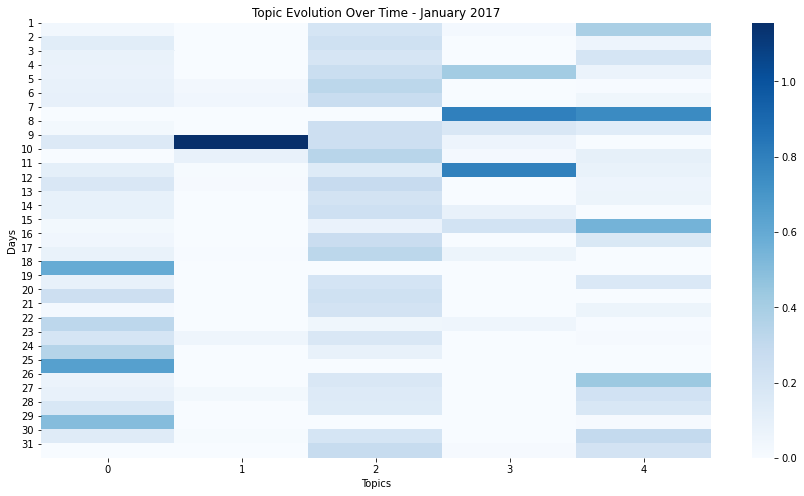

In [25]:
days = list(range(1,32))

plotit(data=f[2], title='Topic Evolution Over Time - {}'.format('January 2017'), yaxis=days, ylabel='Days', xlabel='Topics')

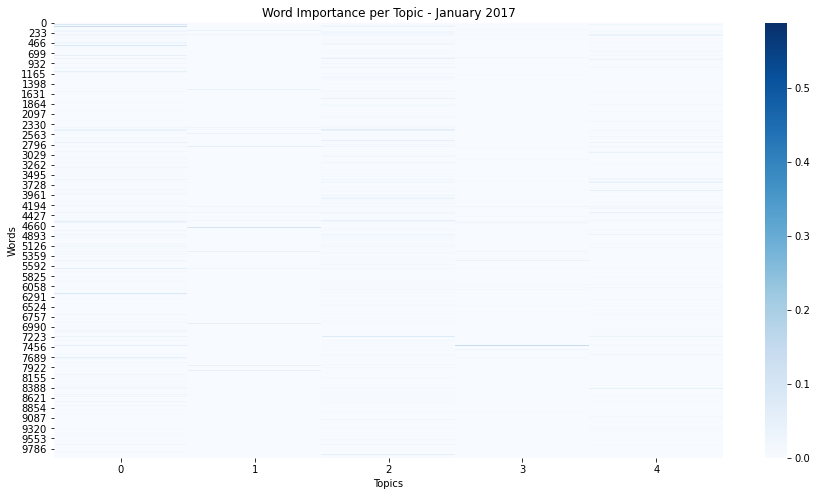

In [26]:
#visualize word importance per topic - should be mode-1 matrix
plotit(data=f[0], title='Word Importance per Topic - {}'.format('January 2017'), ylabel='Words', xlabel='Topics')

In [27]:
#get the words for each topic
words_per_topic = [get_topics(data=f[0][:,i], threshold=0.08, vectorizer=vectorizer) for i in range(5)]
for pos, topic in enumerate(words_per_topic):
    print('\nTopic {}: {}'.format(pos, topic))


Topic 0: ['work' 'woman' 'white' 'washington' 'vote' 'university' 'united' 'two'
 'twitter' 'trump' 'time' 'take' 'statement' 'state' 'saturday' 'right'
 'refugee' 'president' 'potus' 'people' 'order' 'one' 'obama' 'news'
 'national' 'nadal' 'march' 'many' 'make' 'look' 'inauguration'
 'immigration' 'house' 'hill' 'game' 'friday' 'first' 'election' 'donald'
 'day' 'crowd' 'country' 'band' 'back' 'american' 'america'
 'administration' 'account']

Topic 1: ['writer' 'world' 'unmask' 'spotlight' 'shyness' 'shy' 'public' 'pink'
 'perform' 'narcissism' 'musician' 'moran' 'monroe' 'miller' 'media'
 'floyd' 'feel' 'fame' 'escape' 'describe' 'cobain' 'christie' 'audience'
 'attention' 'artist' 'art' 'anxiety' 'agatha' 'act']

Topic 2: ['year' 'text' 'tell' 'take' 'show' 'reuter' 'report' 'price' 'percent'
 'one' 'new' 'market' 'last' 'jan' 'high' 'company' 'billion' 'bank']

Topic 3: ['washington' 'ward' 'view' 'trump' 'thread' 'survive' 'suite'
 'subsidiary' 'street' 'spd' 'site' 'signature'